# Running 'ellipse':

First, we read a test image.

This is the image formerly distributed with the IRAF software as dev$pix. 

Note that the M51 galaxy, with its proeminent spiral arms and giant HII regions, is not the best subject for an algorithm that assumes that isophotes are mainly elliptical in shape. On the other hand, the M51 image is ideal for checking the resilience of the algorithm against image contamination and low signa-to-noise situations.

In [1]:
from astropy.io import fits
image = fits.open("../../test/data/M51.fits")
pixel_data = image[0].data

Create an instance of the Ellipse class, passing the numpy 2-D array with the pixel data as argument to the constructor:

In [2]:
from ellipse.ellipse import Ellipse

ellipse = Ellipse(pixel_data)

Finally, run the fit_image method on the instance, getting as result an instance of class IsophoteList.

This may take a while. Wait until all the output prints out, down to the SMA = 0 central intensity value. This interpreted version of the algorithm is significantly slower than the old, compiled code in the IRAF system. In this implementation, we traded speed for flexibility. 

In [3]:
isophote_list = ellipse.fit_image(verbose=True)

#
# Semi-    Isophote      Ellipticity   Position    Grad.  Data  Flag  Iter. Stop
# major      mean                       Angle       rel.                    code
# axis     intensity                               error
#(pixel)                               (degree)
#
  10.00     1087.19        0.098        67.76      0.193    60    0    20     0
  11.00     1045.31        0.134        73.17      0.157    64    0    10     0
  12.10      988.67        0.157        68.42      0.158    70    0    10     0
  13.31      884.66        0.022        52.72      0.490    83    0    50     2
  14.64      857.60        0.022        52.72      0.521    91    0     3     5
  16.11      961.28        0.403        52.72      0.313    77    0    50     2
  17.72      887.29        0.358        50.58      0.145    88    0    10     0
  19.49      756.85        0.179        35.12      0.110   110    0    10     0
  21.44      681.95        0.211        35.82      0.153   119    0    10     0
  23.58  

In [4]:
type(isophote_list)

ellipse.isophote.IsophoteList

### Running 'ellipse' in a finer-grained way:

We can fit individual ellipses as well, by just calling the 'fit_isophote' method in the same Ellipse instance (passing the semi-major axis length to the method):

In [5]:
isophote = ellipse.fit_isophote(20.)

from ellipse.isophote import print_header
print_header(verbose=True)
isophote.print(verbose=True)

#
# Semi-    Isophote      Ellipticity   Position    Grad.  Data  Flag  Iter. Stop
# major      mean                       Angle       rel.                    code
# axis     intensity                               error
#(pixel)                               (degree)
#
  20.00      734.53        0.186        34.44      0.115   113    0    13     0


Note that in this case we get an instance of class Isophote, not IsophoteList as before:

In [6]:
type(isophote)

ellipse.isophote.Isophote

Regarding the example above, by calling the 'fit_isophote' method in a simple 'for' loop with successive values for the semi-major axis length, one may be lead to think that it will emulate the behavior of the 'fit_image' method. However, that would not in general result in the best fits. The fitting algorithm is quite sensitive to the initial guesses (the starting ellipse geometry) and other fitting parameters such as the step used to move from a given ellipse to the next, the area integration method, finding the maximum acceptable semi-major axis length, and such. The 'fit_image' method takes care of handling these details in a transparent way for the user.

In the 'isophote' package, the class constructors and method calls accept a variety of parameters that can be used to customize and fine-tune the fit process. Here we give a few eaxamples; please consult the code documentation for a complete description. 

For instance, the fit algorithm is quite sensitive to the initial guesses for the X and Y position of the center of the galaxy on the frame. When using default values as in the examples above, the methods assume that the galaxy is exactly centered in the frame. The fit algorithm can also fail to properly converge if either the ellipticiy or the position angle of the semi-major axis are too way off the true values. To override that, we should initialize the Ellipse constructor with an instance of class Geometry. This class encapsulates all data and behavior associated with a given ellipse's geometry.

In [7]:
import numpy as np
from ellipse.geometry import Geometry

# user defines here the geometry parameters that will be used as first guess.
x0 = 256.    # center position
y0 = 256.    # center porsition
sma = 20.    # semi-major axis length in pixels
eps = 0.2    # ellipticity

# positon angle is defined in radians, counterclockwise from the
# +X axis. Here we use 35 degrees as a first guess.
pa = 35. / 180. / np.pi

# note that the Geometry constructor has additional parameters with
# default values. Please see the class documentation for details.
g = Geometry(x0, y0, sma, eps, pa)

# the custom geometry is passed to the Ellipse constructor.
ellipse = Ellipse(pixel_data, geometry=g)

# the fit proceeds as usual.
isophote = ellipse.fit_isophote(20.)

isophote.print(verbose=True)

  20.00      713.84        0.244        43.97      1.926   108    0     7    -1


To further break down the fit process, one could explictly work with the Sample and Fitter classes, as exemplified below.

In [8]:
from ellipse.sample import Sample
from ellipse.fitter import Fitter

sample = Sample(pixel_data, 40, geometry=g)
fitter = Fitter(sample)
isophote = fitter.fit()

isophote.print(verbose=True)

  40.00      341.32        0.241        12.35      0.125   217    0    10     0


In here, we initially create an instance of the Sample class. This instance encapsulates everything associated with a given elliptical path over the image. This includes not only the geometry information, but also the raw intensity samples extracted from the image, as well as associated photometric quantities. 

Note that the Sample constructor allows for overriding the semi-major axis length initially used to create the Geometry instance. That way, one can propagate a given geometry configuration to other values of semi-major axis length.

The Sample instance is used to initialize an instance of the Fitter class. This class has a number of controls to help in tweaking the fit. The final result of the 'fit' method is an instance of class Isophote with the final, fitted values of the geometry parameters.

Raw values extracted from the image can be accessed via the 'values' attribute of a Sample instance. This attribute stores a 2-D numpy array. The first element is of length 3, and each one of those has as many elements as there are individual extracted values from the image. 

In [9]:
isophote.sample.values.shape

(3, 217)

The 3 top-level elements contain respectively the position angles, the polar radii, and the intensity values extracted at each position along the elliptical path on the image:

In [10]:
# the first four angles in radians
isophote.sample.values[0][0:4]

array([ 0.0375    ,  0.06251295,  0.0875489 ,  0.11261928])

In [11]:
# the first four polar radii in pixels
isophote.sample.values[1][0:4]

array([ 39.97928514,  39.94256211,  39.88771536,  39.81501848])

In [12]:
# the first four intensities
isophote.sample.values[2][0:4]

array([ 275.74133901,  238.92087891,  230.46307202,  255.36917793])

Note that, in the example above, we cannot use the original Sample instance used to initialize the fitter. Once the fitter does its bidding, that instance becomes invalid and we need to look for a new Sample instance inside the Isophote instance just created.

# Plotting results:

Import packages necessary for plotting:

In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The attributes of an Isophote instance are also attributes of an IsophoteList instance. The difference is, while the individual isophotes have scalar attributes, the same attributes in an IsophoteList are numpy arrays that store the given attribute across all isophotes in the list. Thus, attributes in a IsophoteList can be directly used as parameters for matplotlib calls.

As an example, a basic plot of intensities as a function of (semi-major axis length)^1/4 can be done simply as:

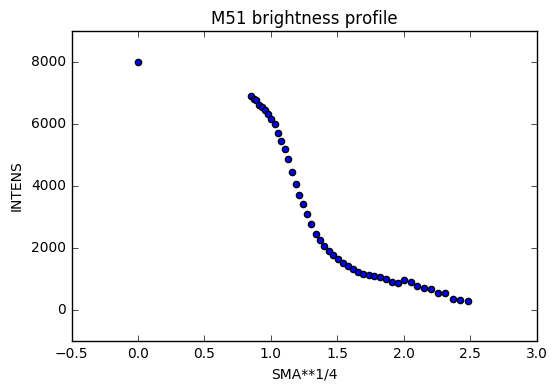

In [19]:
plt.scatter(isophote_list.sma**0.25, isophote_list.intens)

plt.xlabel('SMA**1/4')
plt.ylabel('INTENS')
plt.title("M51 brightness profile")

Next, a multiple plot depicting ellipse geometry as a function of semi-major axis length. Note that the isophote_list attribute 'sample' is a list of instances of Sample, thus it has to be drilled in in order to retrieve the geometry parameters.

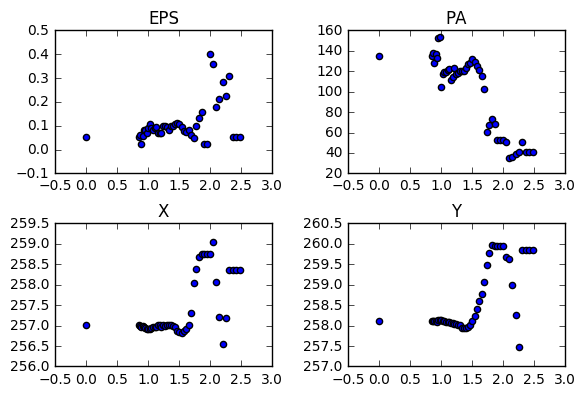

In [15]:
plt.figure(1)

plt.subplot(221)
plt.scatter(isophote_list.sma**0.25, np.array([s.geometry.eps for s in isophote_list.sample]))
plt.title('EPS')

plt.subplot(222)
plt.scatter(isophote_list.sma**0.25, np.array([s.geometry.pa/np.pi*180. for s in isophote_list.sample]))
plt.title('PA')

plt.subplot(223)
plt.scatter(isophote_list.sma**0.25, np.array([s.geometry.x0 for s in isophote_list.sample]))
plt.title('X')

plt.subplot(224)
plt.scatter(isophote_list.sma**0.25, np.array([s.geometry.y0 for s in isophote_list.sample]))
plt.title('Y')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35, wspace=0.35)

Ellipses can be overplotted on the image display:

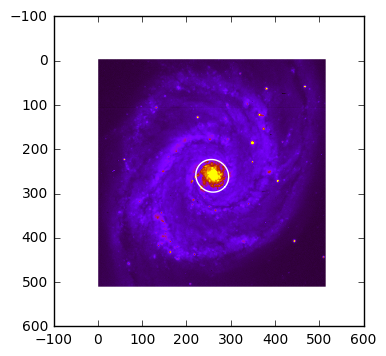

In [16]:
import matplotlib.cm as cm

fig, ax = plt.subplots()
ax.imshow(pixel_data, cmap=cm.gnuplot, vmin=0, vmax=1000)

# this method will retrieve the isophote that has the closest 'sma' from the passed argument.
iso = isophote_list.get_closest(40.)

# this method returns the X-Y coordinates of the sampled points in the image.
x, y, = iso.sampled_coordinates()

plt.plot(x, y, color='white')


The "isophote" doesn't look quite isophotal. This is to be expected in this image though. The fitting algorithm assumes that a smoother surface brightness distribution will dominate the image, and this is hardly the case of M51 with its proeminent spiral arms and lots of clumpy star formation regions. 

We can examine the elliptical brightness sample associated with the ellipse depicted above to get an idea of what is going on. The plot below shows large contamination from those bright HII regions.

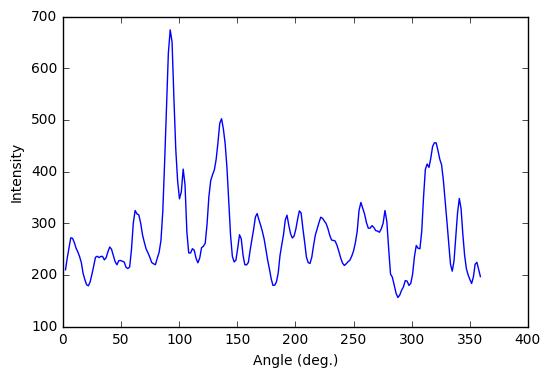

In [20]:
plt.plot(iso.sample.values[0]/np.pi*180., iso.sample.values[2])
plt.ylabel("Intensity")
plt.xlabel("Angle (deg.)")

We can use sigma-clipping to try to get around them. Please see the next notebook example_sclip for a demo of the sigma-clip feature.